In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
import xgboost as xgb

In [5]:
path = os.path.abspath('..') + '/' + "datasets/model_dataset.csv"

df = pd.read_csv(path)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['communication_protocol', 'encryption_type']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['communication_protocol', 'encryption_type']))
df = pd.concat([df.drop(['communication_protocol', 'encryption_type'], axis=1), encoded_df], axis=1)

attack_cols = ['label_spoofing', 'label_mitm', 'label_ddos', 'label_gps_spoofing', 'label_malware', 'label_jamming', 'label_protocol_exploit']
df = df.drop(['timestamp', 'drone_gps_coordinates', 'label_normal'], axis=1)
#df['anomaly'] = df[attack_cols].max(axis=1)
#df = df.drop(columns=attack_cols)

features = df.columns.to_numpy()
features = np.delete(features, -1)

X = df[features]
y = df[attack_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = OneVsRestClassifier(
    xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss'
    )
)

# Fit with eval_set (XGBoost requires eval_set inside XGBClassifier.fit)
for i, label in enumerate(attack_cols):
    print(f"\nTraining classifier for label: {label}")

    model.estimators_.append(
        xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            objective='binary:logistic',
            eval_metric='logloss'
        )
    )

    model.estimators_[i].fit(
        X_train,
        y_train[:, i],
        eval_set=[(X_train, y_train[:, i]), (X_test, y_test[:, i])],
        verbose=False
    )
loss_results = {}

for i, label in enumerate(attack_cols):
    evals = model.estimators_[i].evals_result()
    train_loss = evals['validation_0']['logloss']
    val_loss = evals['validation_1']['logloss']

    loss_results[label] = {
        "train_loss": train_loss,
        "val_loss": val_loss
    }

for label in attack_cols:
    train_loss = loss_results[label]["train_loss"]
    val_loss = loss_results[label]["val_loss"]

    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(f"Log Loss Curve for {label}")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid()
    plt.show()

AttributeError: 'OneVsRestClassifier' object has no attribute 'evals_result'

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       452
           1       1.00      0.98      0.99       233
           2       1.00      0.99      0.99       715
           3       1.00      0.99      1.00       377
           4       1.00      1.00      1.00       509
           5       1.00      0.99      0.99       618
           6       1.00      0.99      1.00       207

   micro avg       1.00      0.99      0.99      3111
   macro avg       1.00      0.99      0.99      3111
weighted avg       1.00      0.99      0.99      3111
 samples avg       0.30      0.30      0.30      3111

Accuracy: 99.6130207147735
Precision: 100.0
Recall: 98.83435561295136
F1 Score: 99.41310015470332


/home/mcha/workspace/CUSE/FALL25/CIS600/CIS600_final_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mcha/workspace/CUSE/FALL25/CIS600/CIS600_final_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mcha/workspace/CUSE/FALL25/CIS600/CIS600_final_project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use

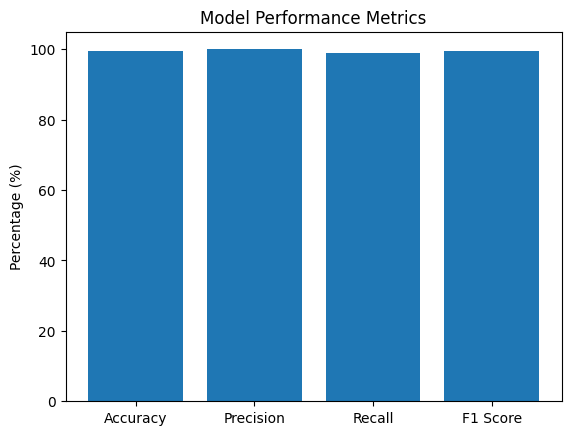

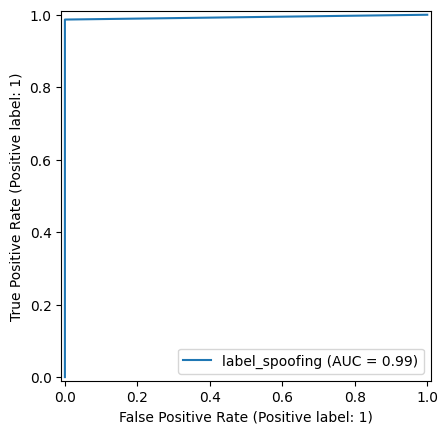

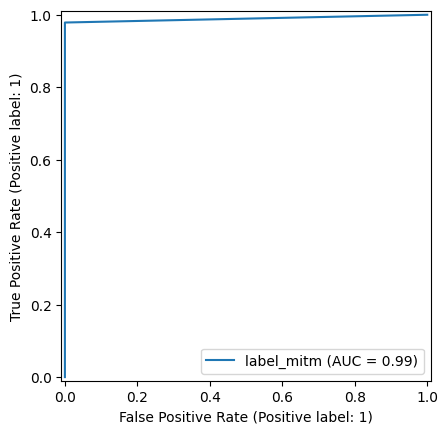

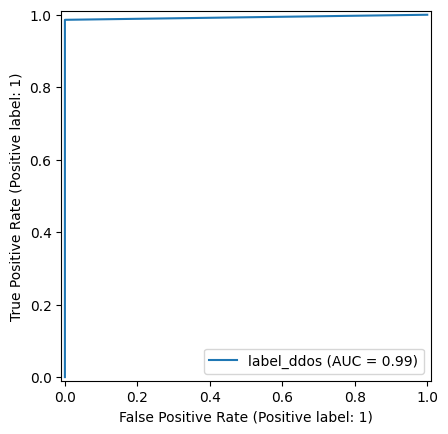

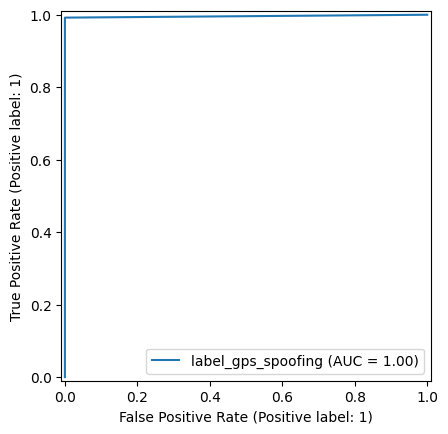

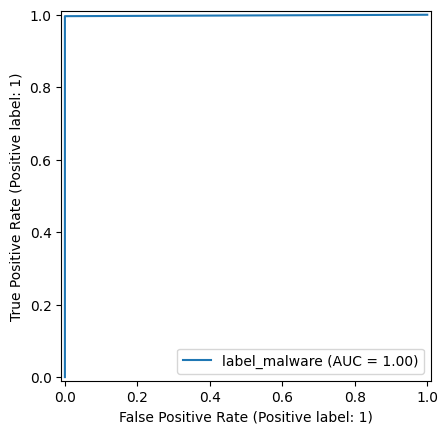

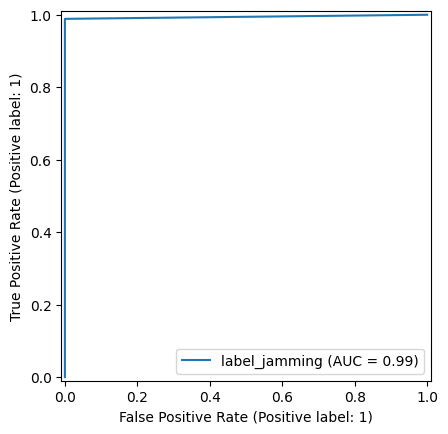

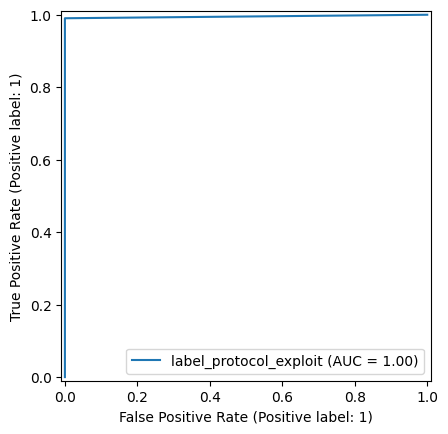

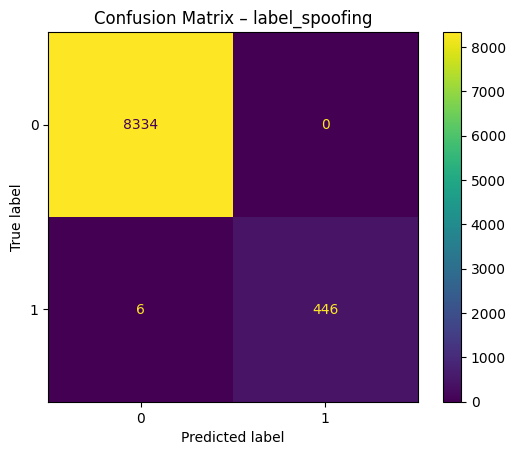

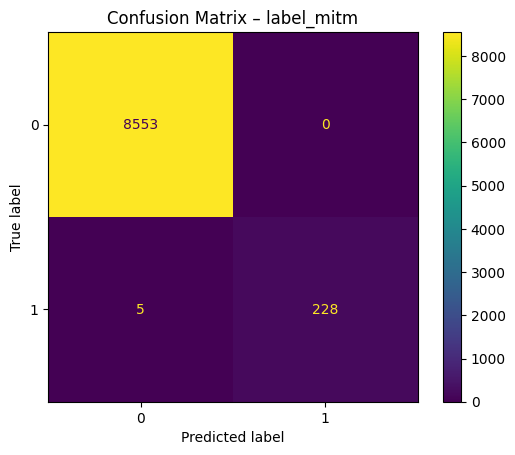

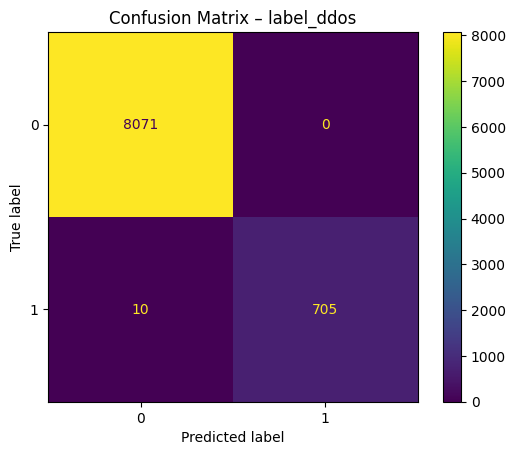

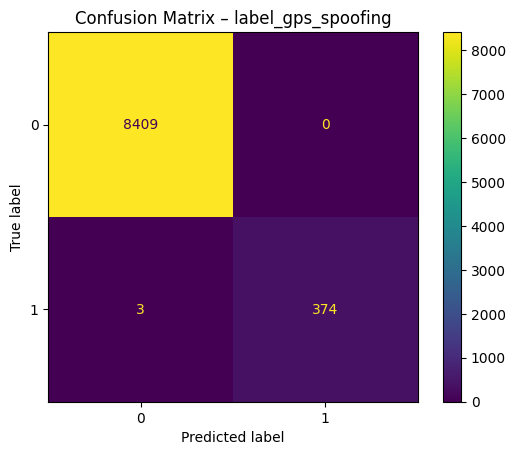

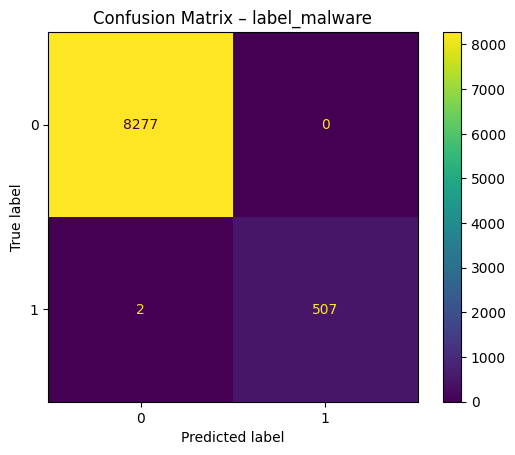

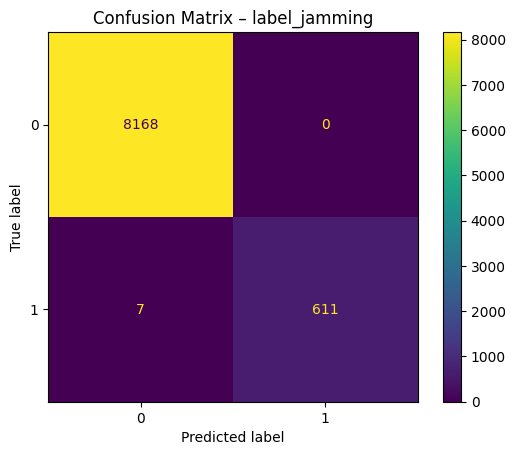

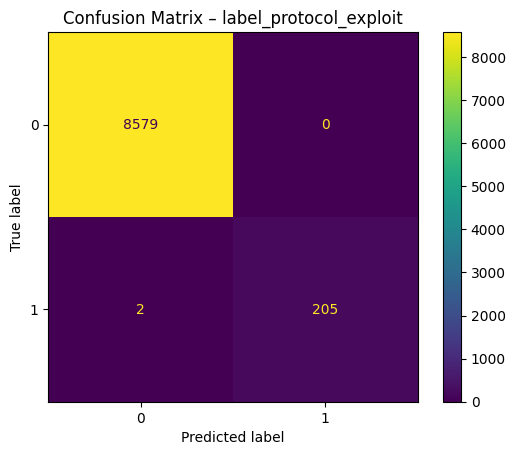

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score:", f1*100)

# BAR GRAPH
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}
plt.bar(metrics.keys(), [v*100 for v in metrics.values()])
plt.ylabel("Percentage (%)")
plt.title("Model Performance Metrics")
plt.show()


for i, label in enumerate(attack_cols):
    RocCurveDisplay.from_predictions(
        y_test[:, i], y_pred[:, i], name=label
    )
plt.show()


for i, label in enumerate(attack_cols):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix – {label}")
    plt.show()


#xgb.plot_importance(model)
#plt.show()